<a href="https://colab.research.google.com/github/JADukeAIPI/AIPIProject/blob/main/LuxuryCarAPIMultipleDates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 510 PROJECT

This will allow for generating a dataframe of 'luxury' cars for several dates (currently set up to start from today and checks for 24 hour bookings for each day for next x days). The groupby at the end shows the number of vehicles available for each day, which could indirectly give us how many reservations if we assume the cars are picked up and returned in atlanta and the fleet inventory is stable.

In [30]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import requests
import datetime
from datetime import datetime, timedelta, date



In [31]:
today_date = datetime.today().strftime('%Y-%m-%d')

def get_date(number_days_from_today):

  end_date = datetime.today() + timedelta(days=number_days_from_today)
  end_date=end_date.strftime('%Y-%m-%d')
  return end_date



Getting Booking.com Rental Car API:


In [20]:
def get_booking_data(start_date, end_date):
	url = "https://booking-com.p.rapidapi.com/v1/car-rental/search"
	querystring = {"drop_off_longitude":"-84.419853","currency":"USD","sort_by":"recommended","drop_off_datetime":end_date + ' 15:00:00',"drop_off_latitude":"33.640411","from_country":"it","pick_up_longitude":"-84.419853","locale":"en-gb","pick_up_datetime":start_date + " 15:00:00","pick_up_latitude":"33.640411"}

	headers = {
		"X-RapidAPI-Key": "8bbb18c5b5mshcb2649ca8814f86p1d30a3jsn5a338ac42c22",
		"X-RapidAPI-Host": "booking-com.p.rapidapi.com"}

	response = requests.request("GET", url, headers=headers, params=querystring)
	results = response.json()
	df = pd.json_normalize(results, record_path =['search_results'])

	return df


In [90]:
def clean_api_df(data_df):
  df_cleaned = data_df.copy()
  
  #filter to the columns we want to keep
  columns_to_keep = ['vehicle_info.v_id', 'vehicle_info.v_name', 'vehicle_info.group', 'vehicle_info.transmission', 'pricing_info.base_price', 'pricing_info.price']
  #filter to the types of vehicles in vehicle.group
  vehicle_groups_to_keep = ['Luxury']
  df_cleaned=df_cleaned[columns_to_keep]
  df_cleaned=df_cleaned[df_cleaned['vehicle_info.group'].isin(vehicle_groups_to_keep)]
  df_cleaned.rename(columns={'vehicle_info.v_id':'Vehicle_id', 'vehicle_info.v_name': 'Vehicle Name', 'vehicle_info.group': 'Category', 'pricing_info.base_price': 'Base Price', 'pricing_info.price': 'Price', 'vehicle_info.transmission': 'Transmission'}, inplace=True)
  df_cleaned.sort_values(by='Base Price', ascending=False, inplace=True)
  return df_cleaned

In [79]:

def get_bookings_multiple_dates(start_date = get_date(1), end_date = get_date(30)):
  dfs = []
  

  day = datetime.strptime(start_date, '%Y-%m-%d')
  last_day = datetime.strptime(end_date, '%Y-%m-%d')
  iterator=0
  while day<last_day:
    date_tuple = (day.strftime('%Y-%m-%d'), (day+timedelta(days=1)).strftime('%Y-%m-%d'))

    df_partial = clean_api_df(get_booking_data(*date_tuple))
    df_partial['Date Pickup']=date_tuple[0]
    df_partial['Date Dropoff'] = date_tuple[1]
    dfs.append(df_partial)
    day=day+timedelta(days=1)


  df = pd.concat([dfs[i] for i in range(len(dfs))], axis=0) 

  return df



In [80]:
get_bookings_multiple_dates('2022-11-18', '2022-11-22')


,Vehicle_id,Vehicle Name,Category,Transmission,Dropoff City,Base Price,Price,Pickup City,Date Pickup,Date Dropoff
200,644881573,Cadillac XTS,Luxury,Automatic,,171.26,178.20,,2022-11-18,2022-11-19
221,636479888,Cadillac XTS,Luxury,Automatic,,164.51,171.18,,2022-11-18,2022-11-19
216,646119413,Cadillac XTS,Luxury,Automatic,,158.72,165.16,,2022-11-18,2022-11-19
213,644901168,Cadillac XTS,Luxury,Automatic,,153.78,160.02,,2022-11-18,2022-11-19
209,636492688,Cadillac XTS,Luxury,Automatic,,147.14,153.11,,2022-11-18,2022-11-19
...,...,...,...,...,...,...,...,...,...,...
104,638489136,Chrysler 300,Luxury,Automatic,,153.38,159.60,,2022-11-21,2022-11-22
85,638446461,Chrysler 300,Luxury,Automatic,,153.38,159.60,,2022-11-21,2022-11-22
75,585207183,Chrysler 300,Luxury,Automatic,,150.92,157.04,,2022-11-21,2022-11-22
94,631938698,Buick LaCrosse,Luxury,Automatic,,150.92,157.04,,2022-11-21,2022-11-22


In [81]:
df_next_60_days = get_bookings_multiple_dates(get_date(1), get_date(60))
df_next_60_days

,Vehicle_id,Vehicle Name,Category,Transmission,Dropoff City,Base Price,Price,Pickup City,Date Pickup,Date Dropoff
200,644881573,Cadillac XTS,Luxury,Automatic,,171.26,178.20,,2022-11-18,2022-11-19
221,636479888,Cadillac XTS,Luxury,Automatic,,164.51,171.18,,2022-11-18,2022-11-19
216,646119413,Cadillac XTS,Luxury,Automatic,,158.72,165.16,,2022-11-18,2022-11-19
213,644901168,Cadillac XTS,Luxury,Automatic,,153.78,160.02,,2022-11-18,2022-11-19
209,636492688,Cadillac XTS,Luxury,Automatic,,147.14,153.11,,2022-11-18,2022-11-19
...,...,...,...,...,...,...,...,...,...,...
126,658163273,Chrysler 300,Luxury,Automatic,,113.00,117.58,,2023-01-15,2023-01-16
46,638446461,Chrysler 300,Luxury,Automatic,,104.36,108.59,,2023-01-15,2023-01-16
35,638489136,Chrysler 300,Luxury,Automatic,,104.36,108.59,,2023-01-15,2023-01-16
19,585207183,Chrysler 300,Luxury,Automatic,,101.89,106.02,,2023-01-15,2023-01-16


In [83]:
cars_available = df_next_60_days.groupby('Date Pickup')['Vehicle Name'].count()
cars_available

Date Pickup
2022-11-18    13
2022-11-19    13
2022-11-20    13
2022-11-21    24
2022-11-22    13
2022-11-25    13
2022-11-26    13
2022-11-27    24
2022-11-28    24
2022-11-29    24
2022-11-30    24
2022-12-01    24
2022-12-02    13
2022-12-03    13
2022-12-04    24
2022-12-05    24
2022-12-06    24
2022-12-07    24
2022-12-08    13
2022-12-09    13
2022-12-10    13
2022-12-11    24
2022-12-12    24
2022-12-13    24
2022-12-14    24
2022-12-15    24
2022-12-16    24
2022-12-17    24
2022-12-18    24
2022-12-19    24
2022-12-20    24
2022-12-21    24
2022-12-22    24
2022-12-23    13
2022-12-24    13
2022-12-25    13
2022-12-26    13
2022-12-27    24
2022-12-28    24
2022-12-29    24
2022-12-30    24
2022-12-31    24
2023-01-01    24
2023-01-02    24
2023-01-03    24
2023-01-04    24
2023-01-05    24
2023-01-06    24
2023-01-07    24
2023-01-08    24
2023-01-09    24
2023-01-10    24
2023-01-11    24
2023-01-12    24
2023-01-13    24
2023-01-14    24
2023-01-15    24
Name: Vehicle Name,

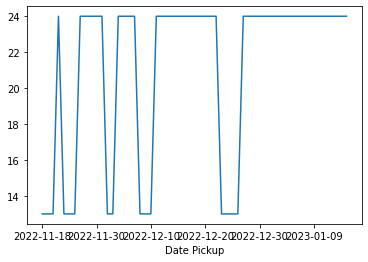

In [123]:
cars_available.plot()

It seems like they usually have 24 such vehicles on hand, so can subtract from 24 to see how many are already reserved for each day (although several days have 13, which may mean they set aside a certain number for those days or contractually lease a certain number and are outside the pool for reservations). Of note, this max number is 2 less than when I checked yesterday for all time points, which may indicate that 2 cars have left the fleet.


In [120]:
#checking to see if the same car has different prices depending on the date

cars_prices = df_next_60_days.groupby(['Vehicle_id', 'Date Pickup'])['Price'].mean()
cars_prices

Vehicle_id  Date Pickup
585207183   2022-11-21     157.04
            2022-11-27      64.18
            2022-11-28      64.18
            2022-11-29      64.18
            2022-11-30      64.18
                            ...  
735898091   2023-01-11     117.84
            2023-01-12     117.84
            2023-01-13     117.84
            2023-01-14     117.84
            2023-01-15     142.98
Name: Price, Length: 1203, dtype: float64

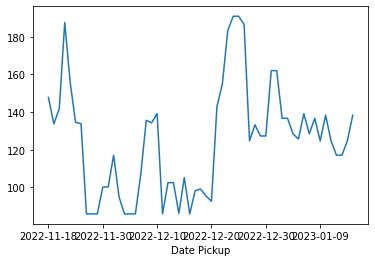

In [122]:
price_each_day = df_next_60_days.groupby('Date Pickup')['Price'].mean()
price_each_day.plot()

In [105]:
def create_df_for_model(df):
  df1=df.copy()
  df1['cars_available'] = df1.groupby('Date Pickup')['Vehicle Name'].transform('count')
  fleet_size = df1['cars_available'].max()
  df1['Reservations'] = df1['cars_available'].apply(lambda x: fleet_size-x)
  df1['Individual_car_prices'] = df1.groupby(['Vehicle_id', 'Date Pickup'])['Price'].transform('mean')
  df1['Avg_type_car_prices'] = df1.groupby(['Vehicle Name', 'Date Pickup'])['Price'].transform('mean')
  df1['Date Pickup'] = pd.to_datetime(df1['Date Pickup'])

  return df1


In [117]:
data = create_df_for_model(df_next_60_days)
data

,Vehicle_id,Vehicle Name,Category,Transmission,Dropoff City,Base Price,Price,Pickup City,Date Pickup,Date Dropoff,cars_available,Reservations,Individual_car_prices,Avg_type_car_prices
200,644881573,Cadillac XTS,Luxury,Automatic,,171.26,178.20,,2022-11-18,2022-11-19,13,11,178.20,147.424000
221,636479888,Cadillac XTS,Luxury,Automatic,,164.51,171.18,,2022-11-18,2022-11-19,13,11,171.18,147.424000
216,646119413,Cadillac XTS,Luxury,Automatic,,158.72,165.16,,2022-11-18,2022-11-19,13,11,165.16,149.086667
213,644901168,Cadillac XTS,Luxury,Automatic,,153.78,160.02,,2022-11-18,2022-11-19,13,11,160.02,147.424000
209,636492688,Cadillac XTS,Luxury,Automatic,,147.14,153.11,,2022-11-18,2022-11-19,13,11,153.11,147.424000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,658163273,Chrysler 300,Luxury,Automatic,,113.00,117.58,,2023-01-15,2023-01-16,24,0,117.58,124.957500
46,638446461,Chrysler 300,Luxury,Automatic,,104.36,108.59,,2023-01-15,2023-01-16,24,0,108.59,110.517500
35,638489136,Chrysler 300,Luxury,Automatic,,104.36,108.59,,2023-01-15,2023-01-16,24,0,108.59,110.517500
19,585207183,Chrysler 300,Luxury,Automatic,,101.89,106.02,,2023-01-15,2023-01-16,24,0,106.02,110.517500
